# County-level Covid-19 Analysis for United States

This notebook utilizes data kindly made available by the New York Times at https://github.com/nytimes/covid-19-data and used for their U.S. tracking page at https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html.  It provides a temporal perspective that complements their excellent geospatial presentation.  The thing about exponentials with a measurable daily growth rate is they change so fast.  With cases increasing 25% per day,
a week means a factor of 5 and a month a factor of a thousand.


* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notbooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/Counties-US-covid19-nytimes.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/Counties-US-covid19.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=Counties-US-covid19.ipynb)
  
## Quick links to sections

* [Select state to study at county level](#selectState)
* [Cases by county](#sectionCases)
* [Deaths by county](#sectionDeaths)
* [Growth trends by county](#sectionGrowth)
* [Projection of cases in one county](#sectionProj)
* [Projection of deaths in one county](#sectionProjDeath)

For dataframes it uses Datascience Tables (for reference see http://data8.org/datascience/tables.html) developed for introductory courses as UCB.

In [12]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [13]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Tools for working with timestamps
day_fmt = "%Y-%m-%d"

def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, day_fmt) < datetime.datetime.strptime(day2, day_fmt)

def format_day(day):
    """Return day """
    date =  datetime.datetime.strptime(day, day_fmt)
    return datetime.datetime.strftime(date, day_fmt)

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, day_fmt) + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, day_fmt)


def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    return np.mean(trend.take[-window:]['rate'])


def project_trend(trend, num_days, rate=None):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend)
        
    day = trend.last('date')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

def cases_since(cases, threshold=100, width=6, height=6):
    _, axis = plots.subplots(figsize=(width, height))
    for region in cases.categories :
        ctbl = cases.extract(region)
        since = ctbl.where(ctbl[region] >= threshold)
        ndays = since.num_rows
        vals = since[region]
        axis.plot(vals)
        axis.text(ndays-1, vals[-1], region)

In [14]:
#URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

countyURL = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

In [15]:
raw_counties = Table.read_table(countyURL)

In [16]:
states = list(np.unique(raw_counties['state']))

<a id='selectState'></a>
## Select state to examine at county level

Choose a state and run all cells below.

In [17]:
w = widgets.Dropdown(
    options = states,
    value ='California',
    # rows=10,
    description='State:',
    disabled=False
)
w

Dropdown(description='State:', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Co…

In [18]:
state = w.value

In [19]:
raw_state = raw_counties.where('state', state)
counties = list(np.unique(raw_state['county']))
cases = TimeTable.from_table(raw_state.pivot('county', 'date', 'cases', sum), time_col = 'date', 
                             time_less_fun=less_day)
deaths = TimeTable.from_table(raw_state.pivot('county', 'date', 'deaths', sum), time_col = 'date',
                             time_less_fun=less_day)

<a id=sectionCases></a>
## Cases to date by county

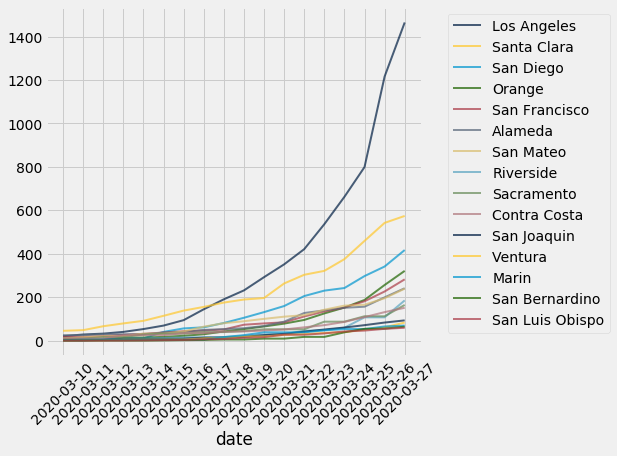

In [20]:
cases.top(15).following('2020-03-10').oplot(height=6, width=6)
_ = plots.xticks(rotation=45)

<a id=sectionDeaths></a>
## Deaths to date by county

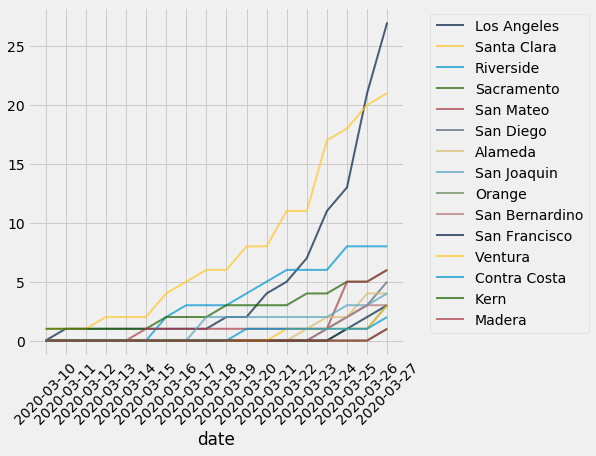

In [21]:
deaths.top(15).following('2020-03-10').oplot(height=6, width=6)
_ = plots.xticks(rotation=45)

<a id='sectionTrends'></a>
## Growth trends by county

In [22]:
cases.order_cols().trend().take[-7:]

date,Los Angeles,new Los Angeles,% newLos Angeles,rate Los Angeles,Santa Clara,new Santa Clara,% newSanta Clara,rate Santa Clara,San Diego,new San Diego,% newSan Diego,rate San Diego,Orange,new Orange,% newOrange,rate Orange,San Francisco,new San Francisco,% newSan Francisco,rate San Francisco,Alameda,new Alameda,% newAlameda,rate Alameda,San Mateo,new San Mateo,% newSan Mateo,rate San Mateo,Riverside,new Riverside,% newRiverside,rate Riverside,Sacramento,new Sacramento,% newSacramento,rate Sacramento,Contra Costa,new Contra Costa,% newContra Costa,rate Contra Costa,San Joaquin,new San Joaquin,% newSan Joaquin,rate San Joaquin,Ventura,new Ventura,% newVentura,rate Ventura,Marin,new Marin,% newMarin,rate Marin,San Bernardino,new San Bernardino,% newSan Bernardino,rate San Bernardino,San Luis Obispo,new San Luis Obispo,% newSan Luis Obispo,rate San Luis Obispo,Sonoma,new Sonoma,% newSonoma,rate Sonoma,Santa Barbara,new Santa Barbara,% newSanta Barbara,rate Santa Barbara,Kern,new Kern,% newKern,rate Kern,Placer,new Placer,% newPlacer,rate Placer,Solano,new Solano,% newSolano,rate Solano,Santa Cruz,new Santa Cruz,% newSanta Cruz,rate Santa Cruz,Fresno,new Fresno,% newFresno,rate Fresno,Monterey,new Monterey,% newMonterey,rate Monterey,Tulare,new Tulare,% newTulare,rate Tulare,Stanislaus,new Stanislaus,% newStanislaus,rate Stanislaus,Imperial,new Imperial,% newImperial,rate Imperial,Yolo,new Yolo,% newYolo,rate Yolo,Humboldt,new Humboldt,% newHumboldt,rate Humboldt,El Dorado,new El Dorado,% newEl Dorado,rate El Dorado,Nevada,new Nevada,% newNevada,rate Nevada,Madera,new Madera,% newMadera,rate Madera,San Benito,new San Benito,% newSan Benito,rate San Benito,Napa,new Napa,% newNapa,rate Napa,Mono,new Mono,% newMono,rate Mono,Merced,new Merced,% newMerced,rate Merced,Butte,new Butte,% newButte,rate Butte,Inyo,new Inyo,% newInyo,rate Inyo,Calaveras,new Calaveras,% newCalaveras,rate Calaveras,Shasta,new Shasta,% newShasta,rate Shasta,Siskiyou,new Siskiyou,% newSiskiyou,rate Siskiyou,Yuba,new Yuba,% newYuba,rate Yuba,Amador,new Amador,% newAmador,rate Amador,Mendocino,new Mendocino,% newMendocino,rate Mendocino,Sutter,new Sutter,% newSutter,rate Sutter,Colusa,new Colusa,% newColusa,rate Colusa,Kings,new Kings,% newKings,rate Kings,Unknown,new Unknown,% newUnknown,rate Unknown
2020-03-21,351,59,16.81%,1.20205,263,67,25.48%,1.34184,159,28,17.61%,1.21374,78,13,16.67%,1.2,84,5,5.95%,1.06329,87,20,22.99%,1.29851,110,10,9.09%,1.1,30,2,6.67%,1.07143,52,0,0.00%,1,51,5,9.80%,1.1087,31,6,19.35%,1.24,26,7,26.92%,1.36842,38,0,0.00%,1,9,0,0.00%,1,27,11,40.74%,1.6875,11,0,0.00%,1,17,8,47.06%,1.88889,4,2,50.00%,2,12,3,25.00%,1.33333,19,1,5.26%,1.05556,15,0,0.00%,1,10,0,0.00%,1,11,6,54.55%,2.2,11,0,0.00%,1,5,0,0.00%,1,4,0,0.00%,1,6,0,0.00%,1,2,0,0.00%,1,2,2,100.00%,inf,1,0,0.00%,1,3,0,0.00%,1,5,0,0.00%,1,1,0,0.00%,1,0,0,nan%,nan,0,0,nan%,nan,1,1,100.00%,inf,0,0,nan%,nan,0,0,nan%,nan,2,1,50.00%,2,2,2,100.00%,inf,2,2,100.00%,inf,1,0,0.00%,1,1,0,0.00%,1,0,0,nan%,nan,0,0,nan%,nan,0,0,nan%,nan,0,0,nan%,nan
2020-03-22,421,70,16.63%,1.19943,303,40,13.20%,1.15209,205,46,22.44%,1.28931,95,17,17.89%,1.21795,111,27,24.32%,1.32143,127,40,31.50%,1.45977,117,7,5.98%,1.06364,45,15,33.33%,1.5,52,0,0.00%,1,61,10,16.39%,1.19608,41,10,24.39%,1.32258,30,4,13.33%,1.15385,38,0,0.00%,1,17,8,47.06%,1.88889,27,0,0.00%,1,11,0,0.00%,1,18,1,5.56%,1.05882,5,1,20.00%,1.25,12,0,0.00%,1,19,0,0.00%,1,15,0,0.00%,1,10,0,0.00%,1,14,3,21.43%,1.27273,12,1,8.33%,1.09091,8,3,37.50%,1.6,4,0,0.00%,1,6,0,0.00%,1,2,0,0.00%,1,2,0,0.00%,1,1,0,0.00%,1,3,0,0.00%,1,5,0,0.00%,1,3,2,66.67%,3,0,0,nan%,nan,0,0,nan%,nan,2,1,50.00%,2,0,0,nan%,nan,0,0,nan%,nan,2,0,0.00%,1,2,0,0.00%,1,2,0,0.00%,1,1,0,0.00%,1,1,0,0.00%,1,0,0,nan%,nan,0,0,nan%,nan,0,0,nan%,nan,1,1,100.00%,inf
2020-03-23,536,115,21.46%,1.27316,321,18,5.61%,1.05941,230,25,10.87%,1.12195,125,30,24.00%,1.31579,134,23,17.16%,1.20721,139,12,8.63%,1.09449,142,25,17.61%,1.21368,48,3,6.25%,1.06667,87,35,40.23%,1.67308,71,10,14.08%,1.16393,51,10,19.61%,

In [23]:
def show_cty(county):
    cases.extract(county).trend().take[-10:].show()
    cases.extract(county).trend().select(['date', county, 'new']).take[-20:].plot('date')
    _ = plots.xticks(rotation=45)
    
_ = interact(show_cty, county=counties)

interactive(children=(Dropdown(description='county', options=('Alameda', 'Amador', 'Butte', 'Calaveras', 'Colu…

<a id='sectionProj'></a>
## Projection of cases in one county

In [24]:
def proj_cty(county):
    proj = project_trend(cases.extract(county).trend().take[-7:], 14)
    proj.show()
    proj.select(['date', county, 'new']).plot('date', width = 7)
    last = cases['date'][-1]
    plots.plot([last, last], [0, proj[county][-1]])
    _ = plots.xticks(rotation=45)
_ = interact(proj_cty, county=counties)

interactive(children=(Dropdown(description='county', options=('Alameda', 'Amador', 'Butte', 'Calaveras', 'Colu…

<a id='sectionProjDeath'></a>
## Projection of deaths in one county

In [25]:
def proj_cty_deaths(county):
    proj = project_trend(deaths.extract(county).trend().take[-7:], 14)
    proj.show()
    proj.select(['date', county, 'new']).plot('date', width = 7)
    last = deaths['date'][-1]
    plots.plot([last, last], [0, proj[county][-1]])
    _ = plots.xticks(rotation=45)
_ = interact(proj_cty_deaths, county=counties)

interactive(children=(Dropdown(description='county', options=('Alameda', 'Amador', 'Butte', 'Calaveras', 'Colu…